In [1]:
# use dream_proj conda environment
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr, spearmanr, gmean
import statsmodels.formula.api as smf

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data

# Palettes

In [6]:
# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']

# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-1])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

<Axes: ylabel='value'>

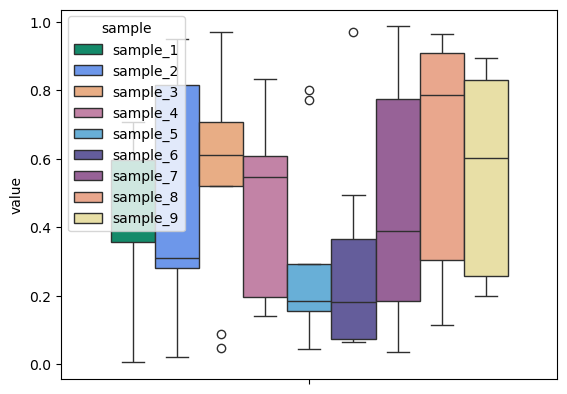

In [7]:
# create random data with 8 samples
np.random.seed(42)
data = np.random.rand(9, 9)
df = pd.DataFrame(data, columns=['sample_{}'.format(i) for i in range(1, 10)])
# pivot long
df = df.melt(var_name='sample', value_name='value')
sns.boxplot(data = df, hue = 'sample', y = 'value', palette = my_categorical_palette)

# Read data

In [37]:
loader = read_data.DatasetLoader("CPTAC-3", load_methylation=False, load_expression=True)
cptac_expr, cptac_mut, _ = loader.load_dataset()

Loading dataset: CPTAC-3
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_expression.tsv
Unknown file type: /cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores_no_DREAM_reg_genes.parquet
Loaded metadata for CPTAC-3
Created ExpressionDataset for CPTAC-3
Created MutationDataset for CPTAC-3


# DREAM expression vs. mutation burden

### Get DREAM regulated expression

In [38]:
cptac_expr.log_scale_expr()

In [39]:
cptac_expr.get_dream_gene_expression(
    #row_limiting_query = "dna_repair_genes == True"
    )   
# get rows that start with 'C3N-00150'
cptac_expr.dream_expression['mean_dream_reg_expr'] = cptac_expr.dream_expression[cptac_expr.dream_regulated_genes_w_expression].mean(axis=1)
cptac_expr.dream_expression['median_dream_reg_expr'] = cptac_expr.dream_expression[cptac_expr.dream_regulated_genes_w_expression].median(axis=1)
# calculate geometric mean, accounting for zeros
cptac_expr.dream_expression['geometric_mean_dream_reg_expr'] = cptac_expr.dream_expression[cptac_expr.dream_regulated_genes_w_expression].apply(lambda row: gmean(row), axis=1)

Did not need to convert DREAM genes
Found 322 DREAM genes with expression


##### Dream regulated genes are upregulated in tumors

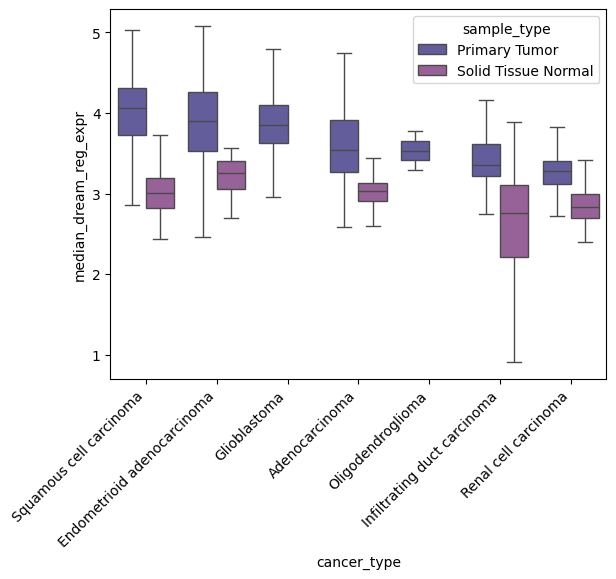

In [13]:
# order by median dream expression in all samples
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('cancer_type')['median_dream_reg_expr'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression,
    x = 'cancer_type', 
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    order = plot_order,
    showfliers = False,
    palette=my_categorical_palette[5:7]
    )
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

<Axes: xlabel='tissue', ylabel='median_dream_reg_expr'>

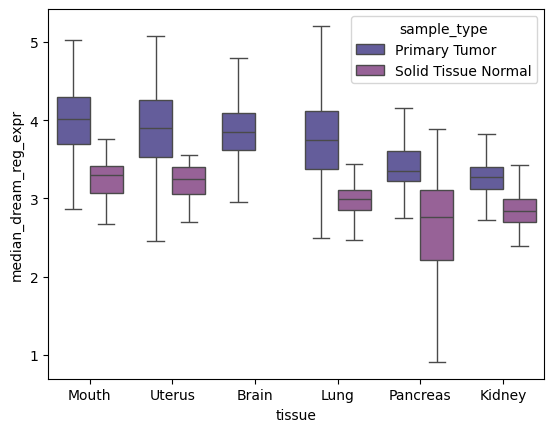

In [14]:
plot_order = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'").groupby('tissue')['median_dream_reg_expr'].median().sort_values(ascending=False).index
# all dream 
sns.boxplot(
    data = cptac_expr.dream_expression, 
    x = 'tissue', 
    y = 'median_dream_reg_expr', 
    hue = 'sample_type',
    order = plot_order,
    showfliers=False,
    palette=my_categorical_palette[5:7]
    )

##### Dream regulated gene expression does not change with age

In [298]:
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
spearmanr(normal_tissue_dream_expr['age_at_index'],normal_tissue_dream_expr['median_dream_reg_expr'], nan_policy='omit')

SignificanceResult(statistic=0.0527967978747439, pvalue=0.19211078275203863)

In [299]:
tumor_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Primary Tumor'")
spearmanr(tumor_tissue_dream_expr['age_at_index'],tumor_tissue_dream_expr['median_dream_reg_expr'], nan_policy='omit')

SignificanceResult(statistic=0.013819465608595632, pvalue=0.5900807115136915)

#### Deconvolving cell-cyle

##### With DREAM reg genes in

In [40]:
# deconvolutuion was done in /cellar/users/zkoch/dream/notebooks/010824_cellCycle_deconv.ipynb
cell_cycle_scores = pd.read_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores.parquet')
# merge with dream expression
cptac_expr.dream_expression = cptac_expr.dream_expression.merge(cell_cycle_scores, left_index=True, right_index=True)

In [41]:
corr_by_sample_type = cptac_expr.dream_expression.groupby('sample_type')[['mean_dream_reg_expr', 'median_dream_reg_expr', 'S_score', 'G2M_score']].corr(method='spearman')
corr_by_sample_type

mean_dream_reg_expr  \
sample_type                                                      
Primary Tumor       mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.988387   
                    S_score                           0.669430   
                    G2M_score                         0.870718   
Solid Tissue Normal mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.938112   
                    S_score                          -0.204374   
                    G2M_score                         0.024895   

                                           median_dream_reg_expr   S_score  \
sample_type                                                                  
Primary Tumor       mean_dream_reg_expr                 0.988387  0.669430   
                    median_dream_reg_expr               1.000000  0.643426   
                    S_score                             0.643426  1.000000   
                    G2M_score                           0.878172  0.659201   
Solid Tissue Normal mean_dream_reg_expr                 0.938112 -0.204374   
                    median_dream_reg_expr               1.000000 -0.113728   
                    S_score                            -0.113728  1.000000   
                    G2M_score                           0.108041  0.255492   

                                           G2M_score  
sample_type                                           
Primary Tumor       mean_dream_reg_expr     0.870718  
                    median_dream_reg_expr   0.878172  
                    S_score                 0.659201  
                    G2M_score               1.000000  
Solid Tissue Normal mean_dream_reg_expr     0.024895  
                    median_dream_reg_expr   0.108041  
                    S_score                 0.255492  
                    G2M_score               1.000000

In [108]:
cptac_mut.mutation_burden.shape

(1272, 8)

Text(-40, 5, '$\\rho$ = -0.11')

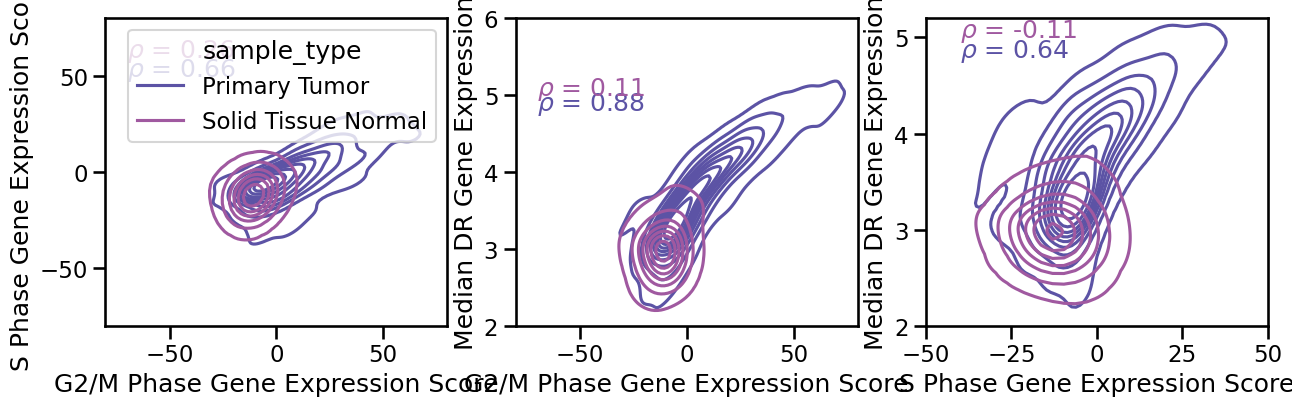

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.set_context('talk')
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score',
    y = 'S_score',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7], 
    ax = axes[0],
    legend = True
    )
# change legend title
axes[0].set_xlim(-80, 80)
axes[0].set_ylim(-80, 80)
axes[0].set_xlabel('G2/M Phase Gene Expression Score')
axes[0].set_ylabel('S Phase Gene Expression Score')
# add the correlation between the two scores for each sample type, use symbol for rho
axes[0].text(-70, 50, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score'),'S_score']), color=my_categorical_palette[5])
axes[0].text(-70, 60, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score'), 'S_score']), color=my_categorical_palette[6])

sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[1]
    )
axes[1].set_xlim(-80, 80)
axes[1].set_ylim(2,6)
axes[1].set_xlabel('G2/M Phase Gene Expression Score')
axes[1].set_ylabel('Median DR Gene Expression')
axes[1].get_legend().remove()
# add the correlation between the two scores for each sample type
axes[1].text(-70, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score'),'median_dream_reg_expr']), color=my_categorical_palette[5])
axes[1].text(-70, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score'), 'median_dream_reg_expr']), color=my_categorical_palette[6])
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'S_score',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[2]
    )

axes[2].set_xlim(-50,50)
axes[2].set_ylim(2,5.2)
axes[2].set_xlabel('S Phase Gene Expression Score')
axes[2].set_ylabel('Median DR Gene Expression')
# remove legend
axes[2].get_legend().remove()
# add the correlation between the two scores for each sample type
axes[2].text(-40, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'S_score'),'median_dream_reg_expr']), color=my_categorical_palette[5])
axes[2].text(-40, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'S_score'), 'median_dream_reg_expr']), color=my_categorical_palette[6])

##### W/out DREAM reg genes

In [ ]:
# deconvolutuion was done in /cellar/users/zkoch/dream/notebooks/010824_cellCycle_deconv.ipynb
cell_cycle_scores = pd.read_parquet('/cellar/users/zkoch/dream/data/tcga/processed_data/CPTAC-3_cell_cycle_scores_no_DREAM_reg_genes.parquet')
# add _no_dream to the column names
cell_cycle_scores.columns = [col + '_no_dream' for col in cell_cycle_scores.columns]
# merge with dream expression
cptac_expr.dream_expression = cptac_expr.dream_expression.merge(cell_cycle_scores, left_index=True, right_index=True)

In [27]:
corr_by_sample_type = cptac_expr.dream_expression.groupby('sample_type')[['mean_dream_reg_expr', 'median_dream_reg_expr', 'S_score_no_dream', 'G2M_score_no_dream']].corr(method='spearman')
corr_by_sample_type

mean_dream_reg_expr  \
sample_type                                                      
Primary Tumor       mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.988387   
                    S_score_no_dream                  0.852437   
                    G2M_score_no_dream                0.868450   
Solid Tissue Normal mean_dream_reg_expr               1.000000   
                    median_dream_reg_expr             0.938112   
                    S_score_no_dream                  0.725175   
                    G2M_score_no_dream                0.598188   

                                           median_dream_reg_expr  \
sample_type                                                        
Primary Tumor       mean_dream_reg_expr                 0.988387   
                    median_dream_reg_expr               1.000000   
                    S_score_no_dream                    0.839715   
                    G2M_score_no_dream                  0.860955   
Solid Tissue Normal mean_dream_reg_expr                 0.938112   
                    median_dream_reg_expr               1.000000   
                    S_score_no_dream                    0.603150   
                    G2M_score_no_dream                  0.405972   

                                           S_score_no_dream  \
sample_type                                                   
Primary Tumor       mean_dream_reg_expr            0.852437   
                    median_dream_reg_expr          0.839715   
                    S_score_no_dream               1.000000   
                    G2M_score_no_dream             0.865589   
Solid Tissue Normal mean_dream_reg_expr            0.725175   
                    median_dream_reg_expr          0.603150   
                    S_score_no_dream               1.000000   
                    G2M_score_no_dream             0.809851   

                                           G2M_score_no_dream  
sample_type                                                    
Primary Tumor       mean_dream_reg_expr              0.868450  
                    median_dream_reg_expr            0.860955  
                    S_score_no_dream                 0.865589  
                    G2M_score_no_dream               1.000000  
Solid Tissue Normal mean_dream_reg_expr              0.598188  
                    median_dream_reg_expr            0.405972  
                    S_score_no_dream                 0.809851  
                    G2M_score_no_dream               1.000000

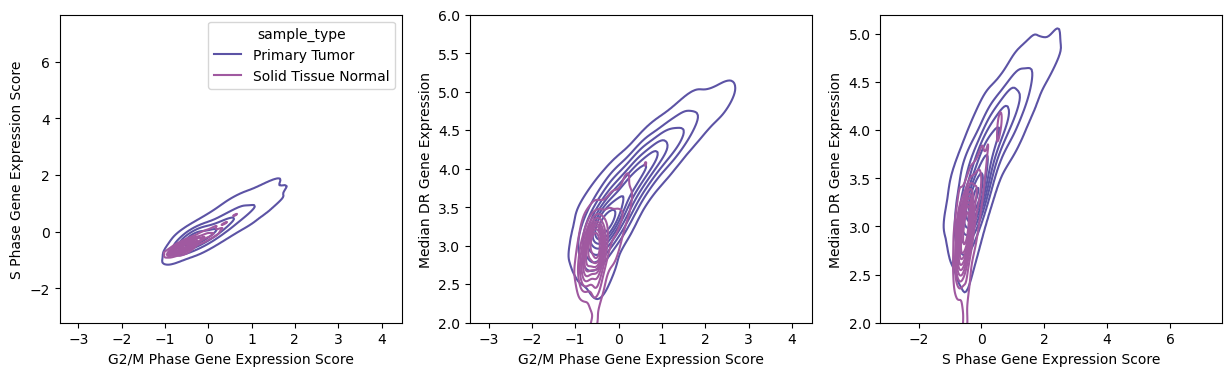

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score_no_dream',
    y = 'S_score_no_dream',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7], 
    ax = axes[0],
    legend = True
    )
#axes[0].set_xlim(-80, 80)
#axes[0].set_ylim(-80, 80)
axes[0].set_xlabel('G2/M Phase Gene Expression Score')
axes[0].set_ylabel('S Phase Gene Expression Score')
# add the correlation between the two scores for each sample type, use symbol for rho
#axes[0].text(-70, 50, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score_no_dream'),'S_score_no_dream']), color=my_categorical_palette[5])
#axes[0].text(-70, 60, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score_no_dream'), 'S_score_no_dream']), color=my_categorical_palette[6])

sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'G2M_score_no_dream',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[1]
    )
#axes[1].set_xlim(-80, 80)
axes[1].set_ylim(2,6)
axes[1].set_xlabel('G2/M Phase Gene Expression Score')
axes[1].set_ylabel('Median DR Gene Expression')
axes[1].get_legend().remove()
# add the correlation between the two scores for each sample type
#axes[1].text(-70, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'G2M_score_no_dream'),'median_dream_reg_expr']), color=my_categorical_palette[5])
#axes[1].text(-70, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'G2M_score_no_dream'), 'median_dream_reg_expr']), color=my_categorical_palette[6])
sns.kdeplot(
    data = cptac_expr.dream_expression,
    x = 'S_score_no_dream',
    y = 'median_dream_reg_expr',
    hue = 'sample_type',
    palette=my_categorical_palette[5:7],
    ax = axes[2]
    )

#axes[2].set_xlim(-50,50)
axes[2].set_ylim(2,5.2)
axes[2].set_xlabel('S Phase Gene Expression Score')
axes[2].set_ylabel('Median DR Gene Expression')
# remove legend
axes[2].get_legend().remove()
# add the correlation between the two scores for each sample type
#axes[2].text(-40, 4.8, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Primary Tumor', 'S_score_no_dream'),'median_dream_reg_expr']), color=my_categorical_palette[5])
#axes[2].text(-40, 5, '$\\rho$ = {:.2f}'.format(corr_by_sample_type.loc[('Solid Tissue Normal', 'S_score_no_dream'), 'median_dream_reg_expr']), color=my_categorical_palette[6])

### Get mutation burdens

/tmp/ipykernel_348296/644110067.py:1: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  sns.scatterplot(


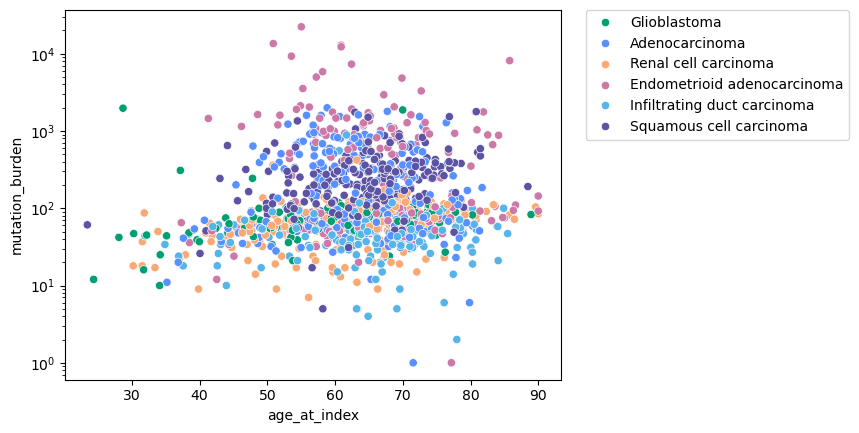

In [43]:
sns.scatterplot(
    data = cptac_mut.mutation_burden.query("num_samples_this_case == 1"),
    x = 'age_at_index', y = 'mutation_burden', hue = 'cancer_type', 
    palette=my_categorical_palette, 
)
plt.yscale('log')
# move legend onto plot
_ =plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Compare dream expression to mutation burden across tissue

<Axes: xlabel='tissue', ylabel='normalized_value'>

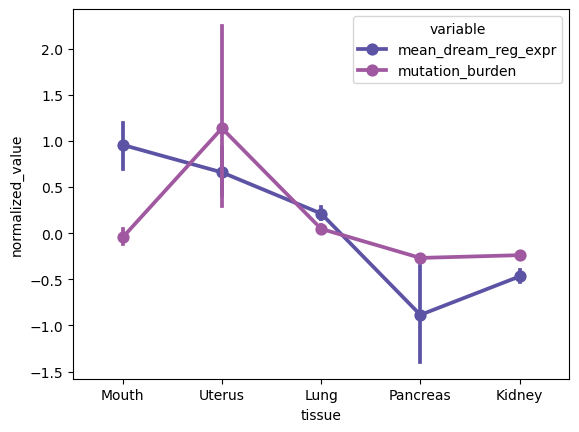

In [58]:
# combine dream expression and mutation burden, for normal tissue only
# have to join on case_id because there are no sample_ids with mutation for normal tissue
normal_tissue_dream_expr = cptac_expr.dream_expression.query("sample_type == 'Solid Tissue Normal'")
normal_expr_v_burden = normal_tissue_dream_expr.merge(
    cptac_mut.mutation_burden[['case_id', 'mutation_burden']], 
    on='case_id', how = 'left'
    )
# want rows with tissue, mean_dream_reg_expr, and mutation_burden
normal_expr_v_burden_long = normal_expr_v_burden.melt(
    id_vars = ['case_id', 'tissue', 'age_at_index'],
    value_vars = ['mutation_burden', 'mean_dream_reg_expr'],
    var_name = 'variable',
    value_name = 'value'
    )
# normalize within each variable value 
normal_expr_v_burden_long['normalized_value'] = normal_expr_v_burden_long.groupby('variable')['value'].transform(lambda x: (x - x.mean()) / x.std())

# set order based on normalized dream expression
orderr = normal_expr_v_burden.groupby('tissue')['mean_dream_reg_expr'].median().sort_values(ascending=False).index
sns.pointplot(
    data = normal_expr_v_burden_long, hue = 'variable', x = 'tissue', y = 'normalized_value',
    palette=my_categorical_palette[5:7],  order = orderr, 
    hue_order=['mean_dream_reg_expr', 'mutation_burden',]
    )

<Axes: xlabel='tissue', ylabel='normalized_value'>

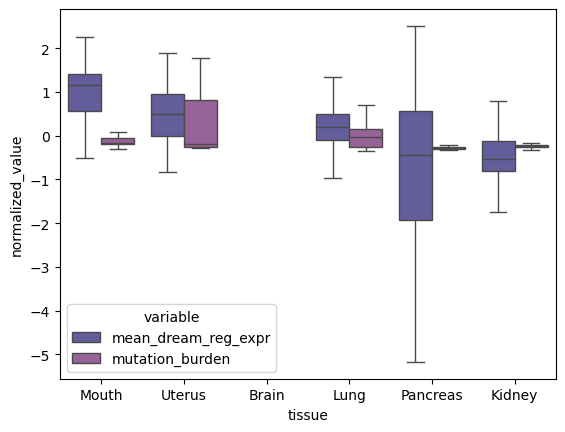

In [59]:
# combine dream expression and mutation burden
dream_exp_v_mut_burden = cptac_expr.dream_expression.merge(
     cptac_mut.mutation_burden, left_index=True, right_index=True, how='left'
    )
# remove _x columns
dream_exp_v_mut_burden = dream_exp_v_mut_burden.loc[:,~dream_exp_v_mut_burden.columns.str.endswith('_x')]
# remive _x from column names
dream_exp_v_mut_burden.columns = dream_exp_v_mut_burden.columns.str.rstrip('_y')
tumor_expr_v_burden = dream_exp_v_mut_burden.dropna(subset=['mutation_burden'])
# want rows with tissue, mean_dream_reg_expr, and mutation_burden
tumor_expr_v_burden_long = normal_expr_v_burden.melt(
    id_vars = ['case_id', 'tissue', 'age_at_index'],
    value_vars = ['mutation_burden', 'mean_dream_reg_expr'],
    var_name = 'variable',
    value_name = 'value'
    )
# normalize within each variable value 
tumor_expr_v_burden_long['normalized_value'] = tumor_expr_v_burden_long.groupby('variable')['value'].transform(lambda x: (x - x.mean()) / x.std())
# set order based on normalized dream expression
orderr = tumor_expr_v_burden.groupby('tissue')['mean_dream_reg_expr'].median().sort_values(ascending=False).index
sns.boxplot(
    data = tumor_expr_v_burden_long, hue = 'variable', x = 'tissue', y = 'normalized_value',
    palette=my_categorical_palette[5:7],  order = orderr, showfliers=False,
    hue_order=['mean_dream_reg_expr', 'mutation_burden',]
    )


### Compare dream expression to mutation burden within each tissue

/tmp/ipykernel_3916144/930487181.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


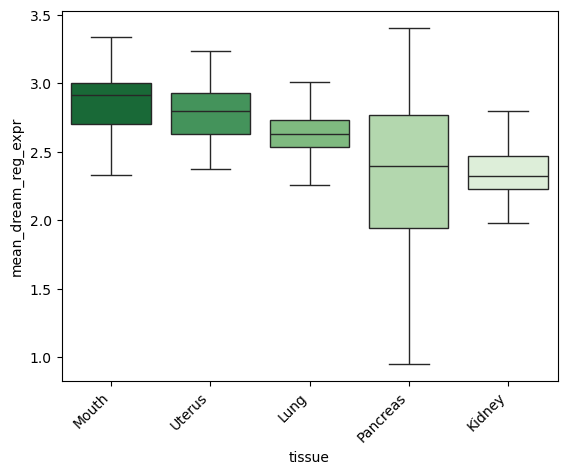

In [306]:
mean_expr_order = normal_expr_v_burden.groupby('tissue')['mean_dream_reg_expr'].median().sort_values(ascending=False).index
sns.boxplot(
    data = normal_expr_v_burden, x = 'tissue', 
    y = 'mean_dream_reg_expr', showfliers=False,
    order=mean_expr_order, palette="Greens_r"
)
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

/tmp/ipykernel_3916144/2069206435.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = normal_expr_v_burden, x = 'tissue', y = 'mutation_burden', showfliers=False, order=burden_order, palette="Greens")


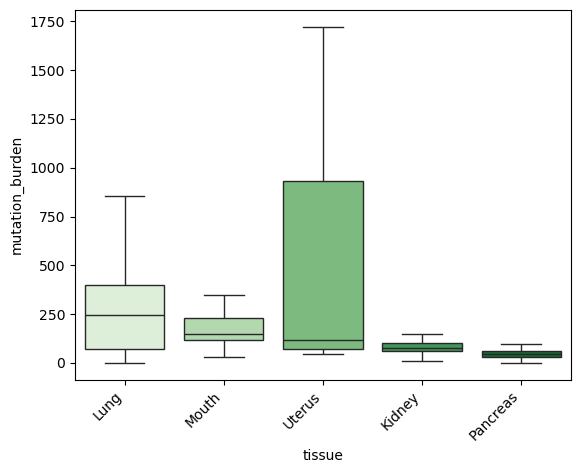

In [254]:
burden_order = normal_expr_v_burden.groupby('tissue')['mutation_burden'].median().sort_values(ascending=False).index
sns.boxplot(data = normal_expr_v_burden, x = 'tissue', y = 'mutation_burden', showfliers=False, order=burden_order, palette="Greens")
# angle the x-axis labels
_ = plt.xticks(rotation=45, ha='right')

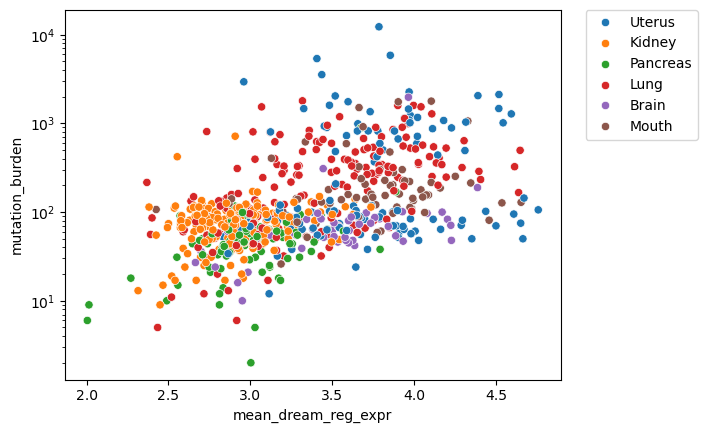

In [307]:
sns.scatterplot(
    data = tumor_expr_v_burden,
    y = 'mutation_burden', x = 'mean_dream_reg_expr', hue = 'tissue',
)
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/tmp/ipykernel_348296/1369408958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'mean_dream_reg_expr':'DREAM Target Gene activity'
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


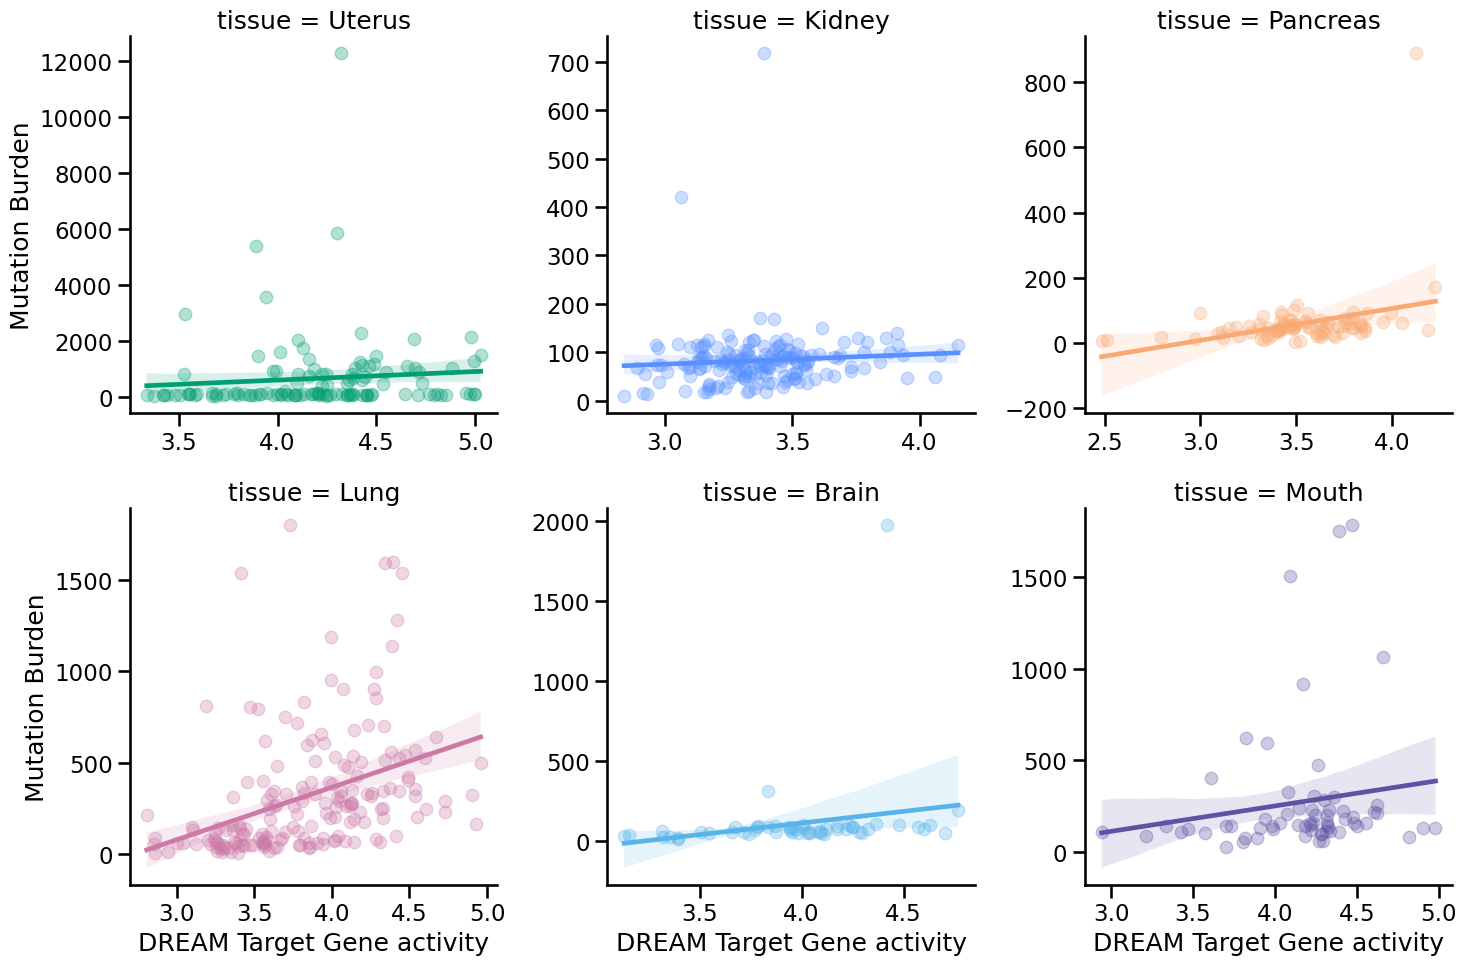

In [109]:
# get the linear equations from the regression
sns.set_context('talk')
tumor_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'mean_dream_reg_expr':'DREAM Target Gene activity'
                                    }, inplace=True)
sns.lmplot(
    data = tumor_expr_v_burden,
    x = 'DREAM Target Gene activity', y = 'Mutation Burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    col_wrap=3,
)



In [87]:
# robust linear model from formula
from statsmodels.robust.robust_linear_model import RLM
# fit robust linear model
robust_model = RLM.from_formula(' mutation_burden~ age_at_index*tissue', data=tumor_expr_v_burden)
results = robust_model.fit()

In [90]:
results.params

Intercept                          53.157737
tissue[T.Kidney]                  -46.801124
tissue[T.Lung]                    -52.467586
tissue[T.Mouth]                   -98.178715
tissue[T.Pancreas]                 -1.056912
tissue[T.Uterus]                   57.753861
age_at_index                        0.261932
age_at_index:tissue[T.Kidney]       0.889271
age_at_index:tissue[T.Lung]         3.073734
age_at_index:tissue[T.Mouth]        3.191867
age_at_index:tissue[T.Pancreas]    -0.311448
age_at_index:tissue[T.Uterus]       0.017422
dtype: float64

In [91]:
mutation_rate = {'Kidney': 0.261932 + 0.889271, 'Lung': 0.261932 + 3.073734, 'Mouth': 0.261932 + 3.191867, 'Pancreas': 0.261932 + 0.311448, 'Uterus': 0.261932 + 0.017422}

/tmp/ipykernel_348296/2556682373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden['Somatic mutation rate (per year)'] = tumor_expr_v_burden['tissue'].map(mutation_rate)


<Axes: xlabel='Somatic mutation rate (per year)', ylabel='mean_dream_reg_expr'>

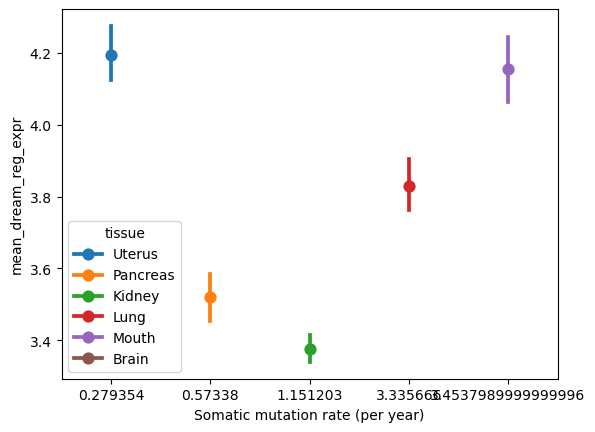

In [97]:
tumor_expr_v_burden['Somatic mutation rate (per year)'] = tumor_expr_v_burden['tissue'].map(mutation_rate)
sns.pointplot(
    data = tumor_expr_v_burden,
    x = 'Somatic mutation rate (per year)', y = 'mean_dream_reg_expr', hue = 'tissue',
)

In [99]:
normal_expr_v_burden[['Somatic mutation rate (per year)', 'mean_dream_reg_expr']].corr()

Somatic mutation rate (per year)  \
Somatic mutation rate (per year)                          1.000000   
mean_dream_reg_expr                                       0.328777   

                                  mean_dream_reg_expr  
Somatic mutation rate (per year)             0.328777  
mean_dream_reg_expr                          1.000000

<Axes: xlabel='Somatic mutation rate (per year)', ylabel='mean_dream_reg_expr'>

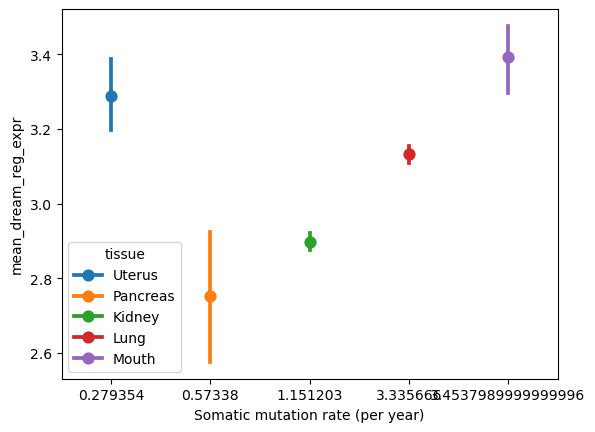

In [98]:
normal_expr_v_burden['Somatic mutation rate (per year)'] = normal_expr_v_burden['tissue'].map(mutation_rate)
sns.pointplot(
    data = normal_expr_v_burden,
    x = 'Somatic mutation rate (per year)', y = 'mean_dream_reg_expr', hue = 'tissue',
)

/tmp/ipykernel_348296/3633096871.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


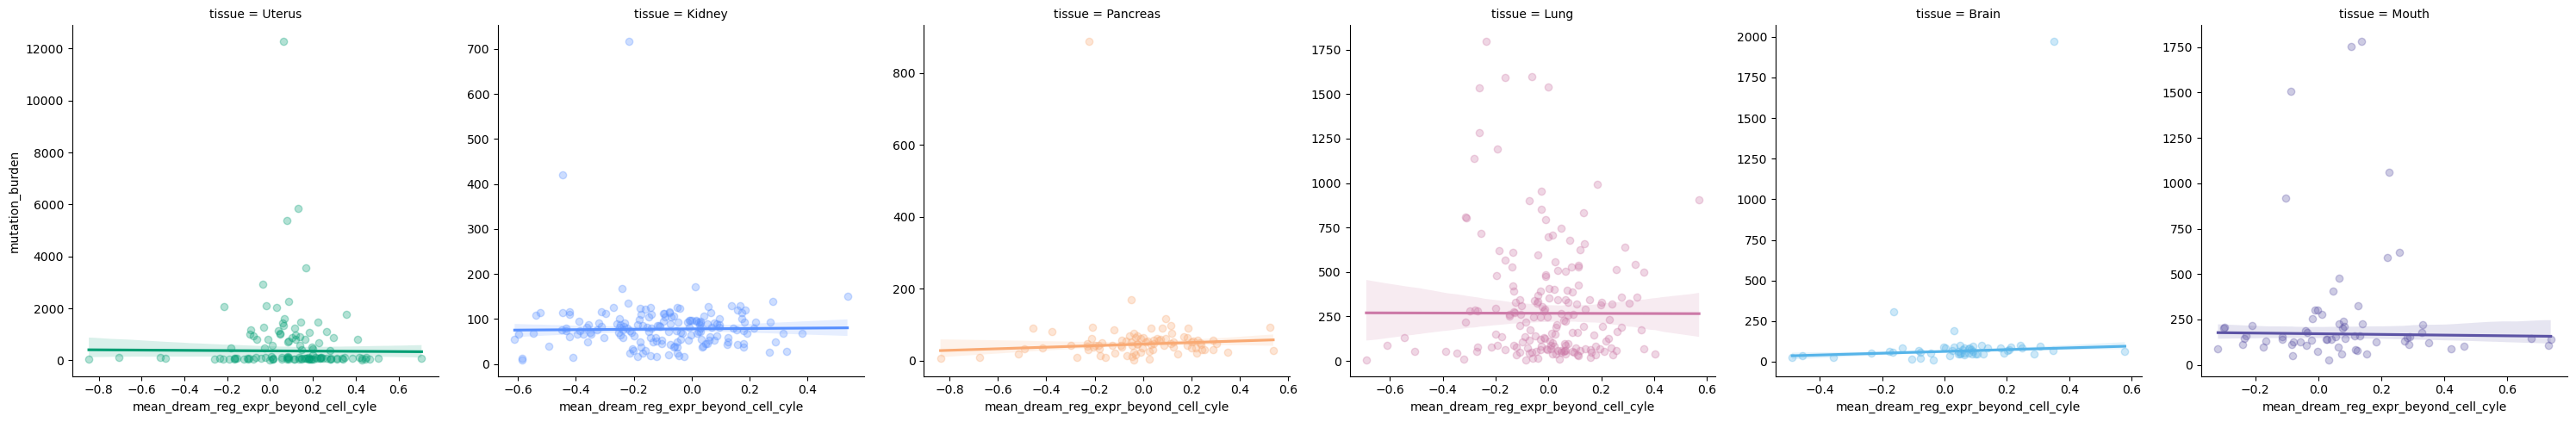

In [100]:

# control dream expression for S_score
# fit linear model
model = smf.ols(formula='mean_dream_reg_expr ~ S_score * G2M_score', data=tumor_expr_v_burden)
results = model.fit()
# add residuals to dataframe
tumor_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
sns.lmplot(
    data = tumor_expr_v_burden,
    x = 'mean_dream_reg_expr_beyond_cell_cyle', y = 'mutation_burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    robust  = True,
)

/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


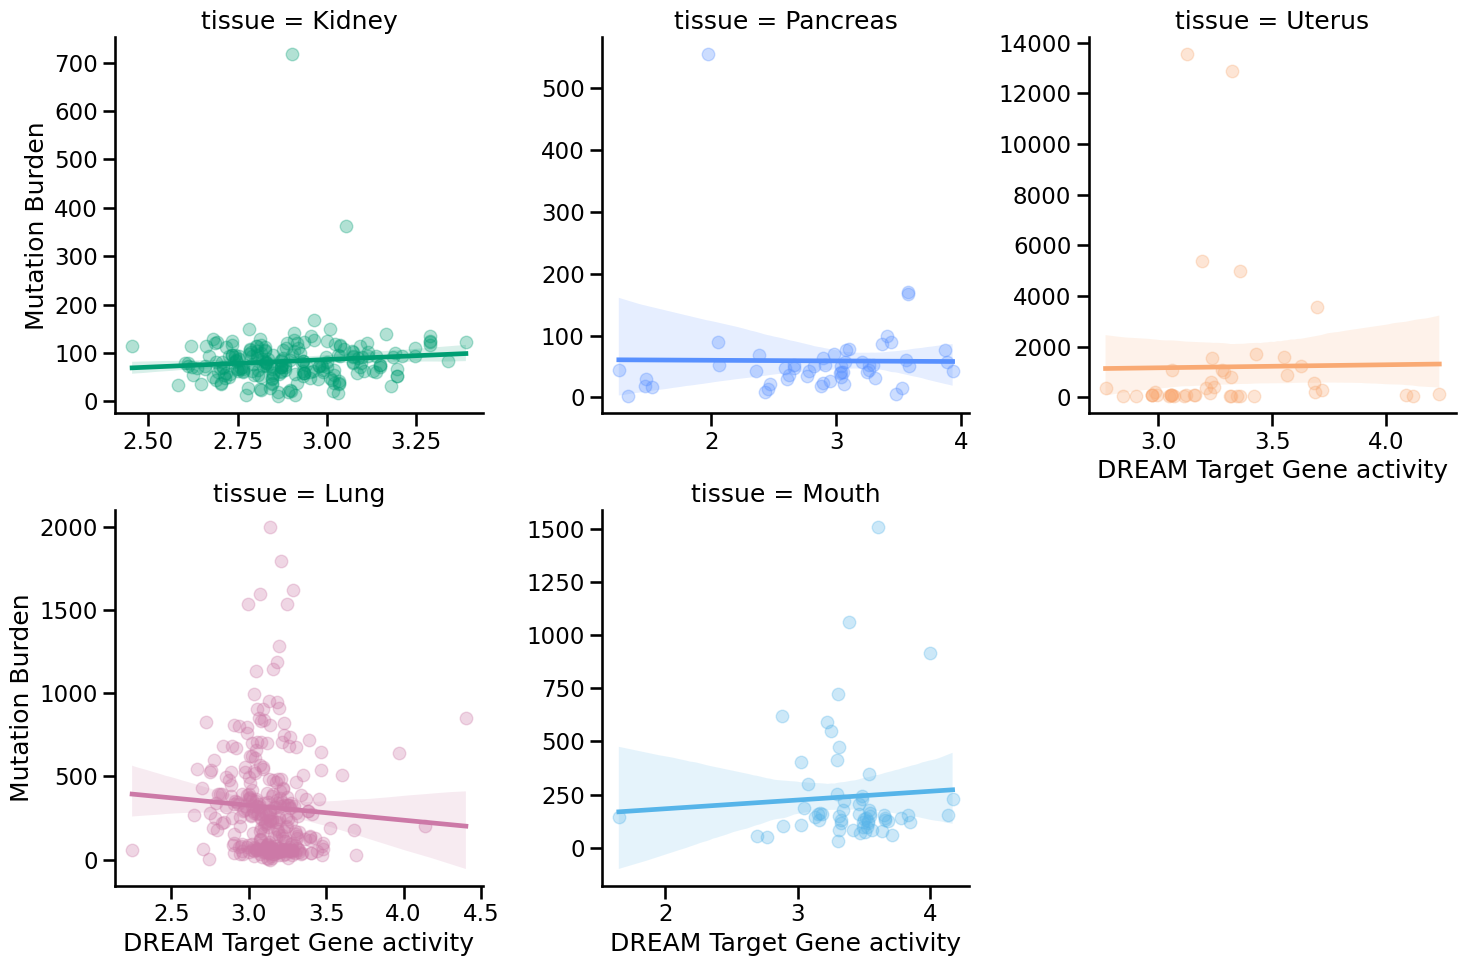

In [111]:

# get the linear equations from the regression
sns.set_context('talk')
normal_expr_v_burden.rename(columns={'mutation_burden':'Mutation Burden', 'mean_dream_reg_expr':'DREAM Target Gene activity'
                                    }, inplace=True)
sns.lmplot(
    data = normal_expr_v_burden,
    x = 'DREAM Target Gene activity', y = 'Mutation Burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
    col_wrap=3,
)



/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/cellar/users/zkoch/miniconda3/envs/dream_proj/lib/python3.12/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


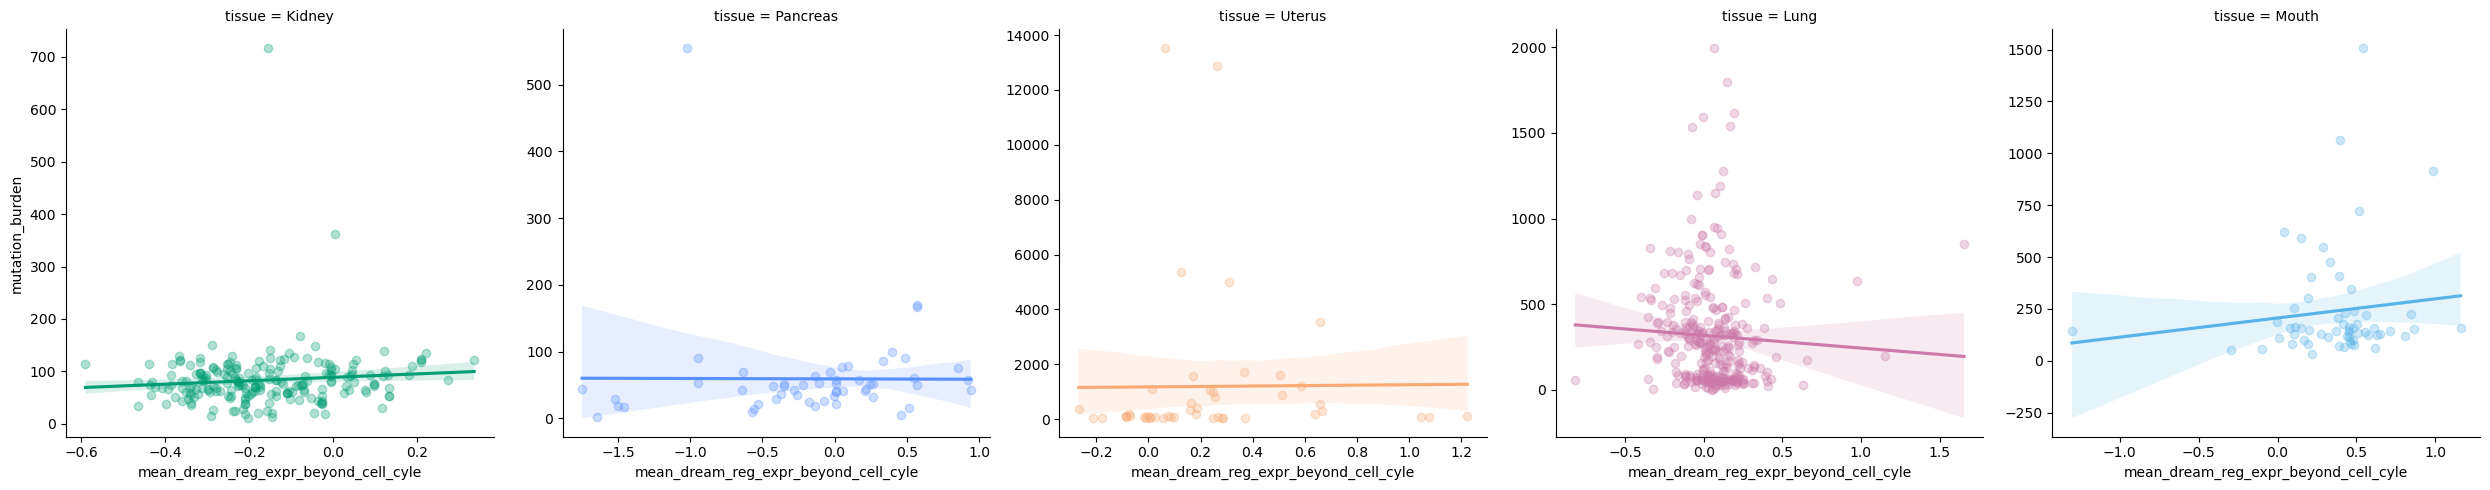

In [70]:
# control dream expression for S_score
# fit linear model
model = smf.ols(formula='mean_dream_reg_expr ~ S_score * G2M_score', data=normal_expr_v_burden)
results = model.fit()
# add residuals to dataframe
normal_expr_v_burden['mean_dream_reg_expr_beyond_cell_cyle'] = results.resid
sns.lmplot(
    data = normal_expr_v_burden,
    x = 'mean_dream_reg_expr_beyond_cell_cyle', y = 'mutation_burden', hue = 'tissue', 
    palette=my_categorical_palette, 
    col = 'tissue',
    scatter_kws={'alpha':0.3},
    sharey=False, sharex=False,
)